In [ ]:
import pysindy as ps
from data._main import get_dataset
from omegaconf import OmegaConf
from utils import NEURONS_302
import numpy as np
from testing.leandro.plots import *
from sklearn.preprocessing import MinMaxScaler
from testing.leandro.plots import *
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

# Testing PySINDy
---

*Code from their examples just to check if it's working*

In [31]:
# Seed the random number generators for reproducibility
np.random.seed(100)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [32]:
# define the testing and training Lorenz data we will use for these examples
dt = 0.002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(
    lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords
).y.T

t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(
    lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T

# define the testing and training data for the Lorenz system with control
def u_fun(t):
    return np.column_stack([np.sin(2 * t), t ** 2])


x_train_control = solve_ivp(
    lorenz_control,
    t_train_span,
    x0_train,
    t_eval=t_train,
    args=(u_fun,),
    **integrator_keywords
).y.T
u_train_control = u_fun(t_train)
x_test_control = solve_ivp(
    lorenz_control,
    t_test_span,
    x0_test,
    t_eval=t_test,
    args=(u_fun,),
    **integrator_keywords
).y.T
u_test_control = u_fun(t_test)

In [33]:
# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=0.4)  # default is lambda = 0.1
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


# Synthetic Data
---

In [34]:
# Load synthetic data
data = np.load('synthetic_data.npz')
x = data['h']
J = data['J']
t = data['time']

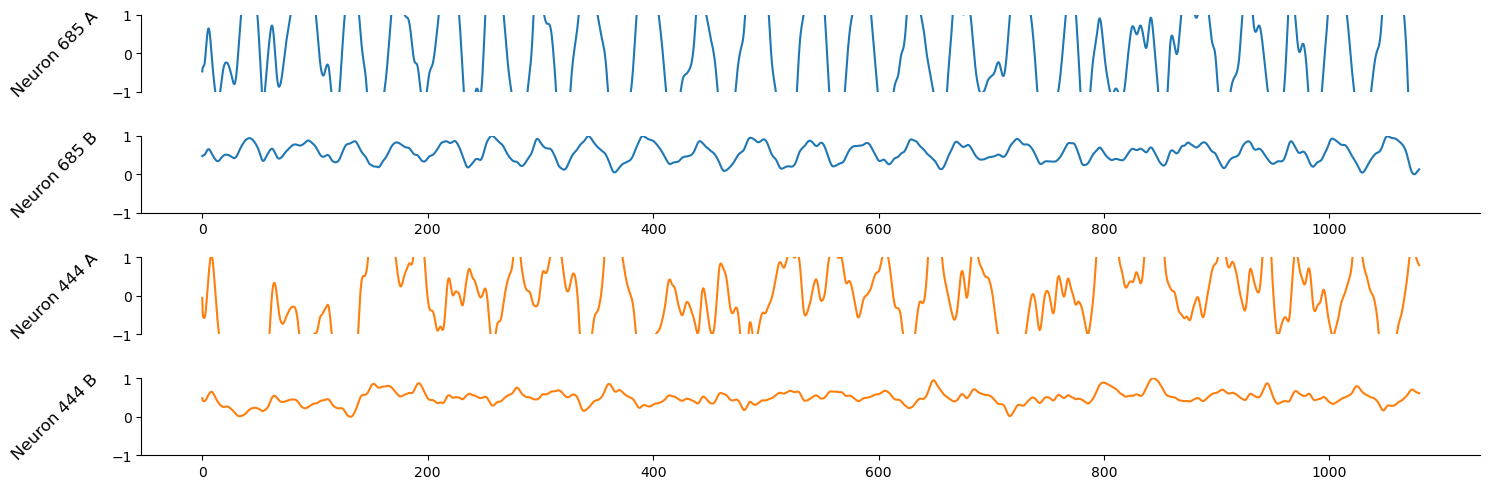

In [35]:
scaler = MinMaxScaler()
scaler.fit(x)
scaled_x = scaler.transform(x)
compare_signals(x, scaled_x, t, 2)

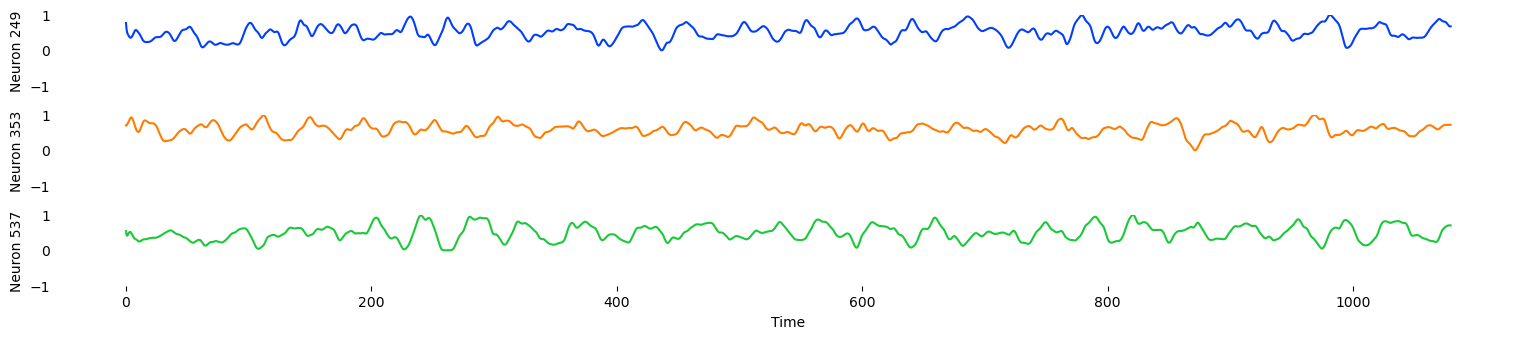

In [36]:
plot_signals(torch.from_numpy(scaled_x), torch.from_numpy(t), 3)

In [37]:
num_neurons = 4
feature_names = ['x'+str(i) for i in range(num_neurons)]
sparse_regression_optimizer = ps.STLSQ(threshold=0)  # default is lambda = 0.1
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(scaled_x[:,:num_neurons], t=0.1)
sim_x = model.simulate(scaled_x[0,:num_neurons], t=t)
model.print()

(x0)' = 0.006 1 + -0.072 x0 + 0.061 x1 + 0.001 x2 + -0.064 x3 + -0.044 x0^2 + 0.069 x0 x1 + 0.089 x0 x2 + -0.004 x0 x3 + -0.117 x1^2 + 0.134 x1 x2 + 0.026 x1 x3 + -0.090 x2^2 + 0.034 x2 x3 + 0.040 x3^2
(x1)' = 0.056 1 + -0.030 x0 + -0.062 x1 + -0.004 x2 + -0.015 x3 + 0.028 x0^2 + 0.052 x0 x1 + -0.121 x0 x2 + 0.098 x0 x3 + -0.015 x1^2 + 0.131 x1 x2 + -0.027 x1 x3 + -0.054 x2^2 + -0.073 x2 x3 + -0.023 x3^2
(x2)' = 0.026 1 + -0.048 x0 + 0.047 x1 + -0.033 x2 + -0.092 x3 + -0.098 x0^2 + 0.163 x0 x1 + 0.048 x0 x2 + -0.084 x0 x3 + -0.154 x1^2 + 0.166 x1 x2 + 0.108 x1 x3 + -0.053 x2^2 + 0.012 x2 x3 + 0.041 x3^2
(x3)' = -0.078 1 + 0.006 x0 + 0.134 x1 + 0.091 x2 + -0.020 x3 + -0.097 x0^2 + 0.057 x0 x1 + 0.080 x0 x2 + -0.040 x0 x3 + -0.020 x1^2 + -0.211 x1 x2 + 0.015 x1 x3 + 0.059 x2^2 + 0.006 x2 x3 + 0.044 x3^2


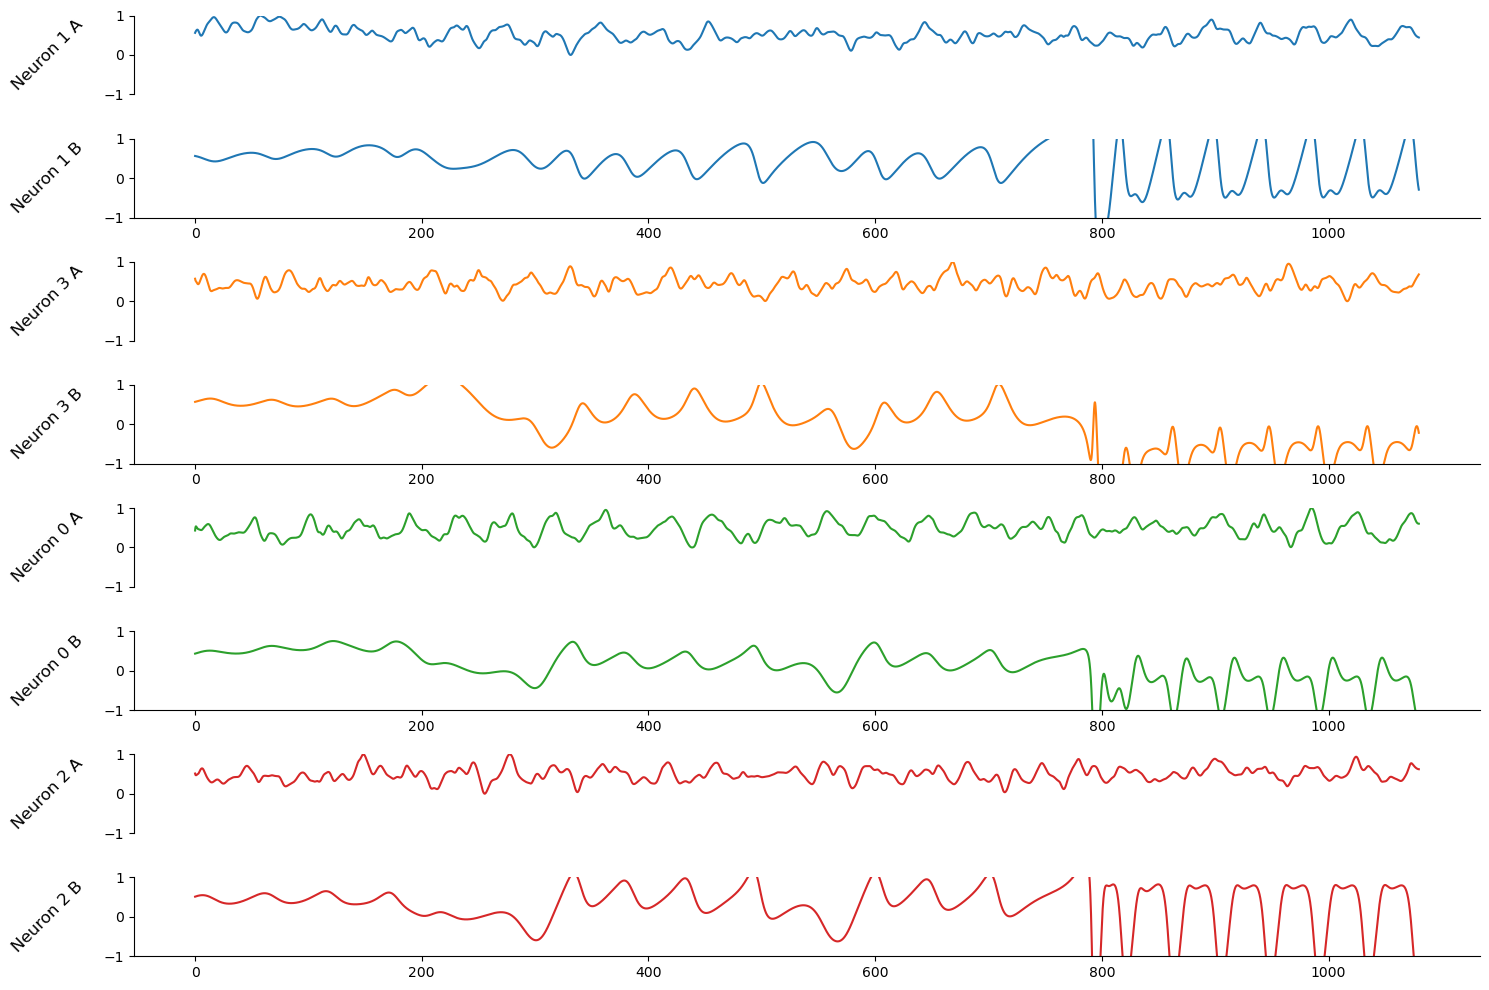

In [38]:
compare_signals(scaled_x[:,:num_neurons], sim_x, t, num_neurons)

# Real Data
---

In [ ]:
config = OmegaConf.load("/om2/user/lrvenan/worm-graph/conf/dataset.yaml")
dataset = get_dataset(config)

In [ ]:
oneWorm = dataset['worm0']
oneWorm.keys()

In [ ]:
X = oneWorm['calcium_data'].detach().numpy()
dt = oneWorm['dt']
print('X shape: {}, dt: {}'.format(X.shape, dt))

In [ ]:
active_neurons = oneWorm['named_neurons_mask']
X_active = X[:, active_neurons]
name_active_neurons = [NEURONS_302[i] for i in range(len(active_neurons)) if active_neurons[i]]

print('Active neurons shape: {}'.format(X_active.shape))
print('Names:')
for n in name_active_neurons:
    print(n, end=', ')

In [ ]:
# Check if we have data of some neurons

searched_neurons = ['AIY', 'AVA', 'AVB', 'RIF', 'SMD', 'DVC']

for n in searched_neurons:
    if n in name_active_neurons:
        print('Found {}'.format(n))
    else:
        print('Not found {}'.format(n))

np.where(np.array(name_active_neurons) == 'DVC')

In [ ]:
fr_library_functions = [
    lambda x, y: -x + np.tanh(y),
]

fr_library_functions_names = [
    lambda x, y: '-' + x + 'tanh(' + y + ')',
]

mylib = ps.CustomLibrary(
    library_functions=fr_library_functions,
    function_names=fr_library_functions_names
)